<a href="https://colab.research.google.com/github/danyentezari/bn-ocr/blob/main/keras_ocr_bignumber_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras==2.2.5
!pip install tensorflow==1.13.1
# !unzip kaggle.json.zip
# !mkdir ~/.kaggle 
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download scolianni/mnistasjpg
# !unzip mnistasjpg.zip
!pip install 'h5py==2.10.0' --force-reinstall
!pip install cairocffi
!pip install gdown
!pip install synthtiger

In [1]:
!git clone https://github.com/clovaai/synthtiger.git
!cp -r synthtiger/* .
!synthtiger -o results -w 4 -c 2000 -v examples/synthtiger/template.py SynthTiger examples/synthtiger/config_horizontal.yaml

fatal: destination path 'synthtiger' already exists and is not an empty directory.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import re
from scipy.sparse import csr_matrix
import cv2
import string
from PIL import Image

import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import keras
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import * #Conv2D, Lambda, MaxPooling2D # convolution layers
#from keras.layers import Dense, Dropout, Flatten # core layers
# from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array


from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
# from keras.layers import Input, Dense, Activation, Add
# from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
#from keras.metrics import Metric
from tensorflow.python.keras.metrics import Metric

import matplotlib.pyplot as plt
%matplotlib inline


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
def loadImage(filepath):
  img = load_img(filepath)
  img = img_to_array(img)
  #img = img.reshape(1, 42, 42, 3)
  # img = img.reshape(64, 192, 3)
  img = img.astype('float32')
  # img = img / 255.0
  return img

### Features and Labels

In [3]:
t1 = [[1, 2, 3], [4, 5, 6]]
t2 = [[7, 8, 9], [10, 11, 12]]
x = tf.concat([t1, t2], 0)
x.eval(session=tf.compat.v1.Session())

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]], dtype=int32)

In [4]:
cw = 200
ch = 80

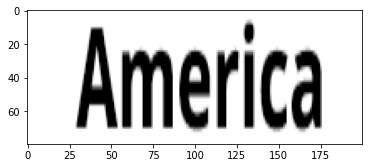

In [5]:
def scale_resize_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32) # equivalent to dividing image pixels by 255
    image = tf.image.resize(image, (ch, cw))
    return image


someimg = load_img('./america.png')

someimg = scale_resize_image( someimg )
# someimg = someimg.astype('float32')

plt.imshow( someimg.eval(session=tf.compat.v1.Session()) )

In [6]:
def create_canvas(canvas_h=300, canvas_w=300):
  # Create canvas
  canvas_color = 255

  pixel_rows = []
  row = [canvas_color for x in range(0,canvas_w)]
  for i in range(0,canvas_h):
    pixel_rows.append(row)
  r = pixel_rows
  g = pixel_rows
  b = pixel_rows

  canvas = np.dstack((r,g,b))
  return canvas

# cw = 950
# ch = 200
canvas = create_canvas(ch, cw)

def center_pad_image(img, canvas_h=300, canvas_w=300):
  # Image positions
  img2_width = img.shape[1]
  img2_height = img.shape[0]
  black_row = np.array([[0 for x in range(0,img2_width)]])
  img2 = np.dstack((black_row,black_row,black_row))


  startx = int((canvas_w-img2_width)/2)
  starty = int((canvas_h-img2_height)/2)
  endx = startx + img2_width
  endy = starty + img2_height

  # Superimpose image
  to_superimpose = Image.fromarray(np.uint8(img)).convert('RGB')
  # Reset global canvas
  canvas[:, :] = 255
  canvas[starty:endy, startx:endx] = to_superimpose


  return Image.fromarray(np.uint8(canvas)).convert('RGB')


# center_pad_image(sample_image, ch, cw)

In [7]:
def create_canvas(canvas_h=300, canvas_w=300):
  # Create canvas
  canvas_color = 0

  pixel_rows = []
  row = [canvas_color for x in range(0,canvas_w)]
  for i in range(0,canvas_h):
    pixel_rows.append(row)
  r = pixel_rows
  g = pixel_rows
  b = pixel_rows

  canvas = np.dstack((r,g,b))
  return canvas

# cw = 300
# ch = 100
canvas = create_canvas(ch, cw)

def negative_pad_image(img, canvas_h=300, canvas_w=300):
  # Image positions
  img2_width = img.shape[1]
  img2_height = img.shape[0]
  black_row = np.array([[0 for x in range(0,img2_width)]])
  img2 = np.dstack((black_row,black_row,black_row))


  startx = 0#int((canvas_w-img2_width)/2)
  starty = 0#int((canvas_h-img2_height)/2)
  endx = startx + img2_width
  endy = starty + img2_height

  # Superimpose image
  to_superimpose = img # Image.fromarray(np.uint8(img)).convert('RGB')
  # Reset global canvas
  canvas[:, :] = 0 #255
  canvas[starty:endy, startx:endx] = to_superimpose


  return canvas #Image.fromarray(np.uint8(canvas)).convert('RGB')

In [8]:
a = tf.constant([[[0], [0], [0]]])
b = tf.constant([[[0], [0], [0]]])

x = tf.concat([a, b], 0)
print(x.eval(session=tf.compat.v1.Session()))
print(x.shape)

[[[0]
  [0]
  [0]]

 [[0]
  [0]
  [0]]]
(2, 3, 1)


In [9]:
a = tf.constant( np.empty((1, ch, cw, 3)), dtype='float32')
b = tf.constant([[0, 0, 0]])
c = tf.constant( np.empty((1, ch, cw, 3)), dtype='float32')


x = tf.concat([a, c], 0)
# print(x.eval(session=tf.compat.v1.Session()))
print(x.shape)

(2, 80, 200, 3)


In [10]:
import re
file1 = open('./results/gt.txt', 'r')
Lines = file1.readlines()

n = 500 #len(Lines)

data_F =  tf.constant( np.zeros([1, ch, cw, 3]), dtype='float32') #tf.constant([[0, 0, 0]]) # np.array([])#np.empty((n, ch, cw, 3))
data_L = [] # tf.constant( np.zeros((1)) ) 


count = 0
# Strips the newline character
for i,line in enumerate(Lines[0:500]):
    d = re.split('\t', line)
    d[1] = d[1].replace('\n','')
    
    img = load_img(f'results/{d[0]}')
    loaded_image = scale_resize_image(img)
    loaded_image = tf.expand_dims(loaded_image, axis=0)

    # print(loaded_image)
    # print(data_F)

    data_F = tf.concat([data_F, loaded_image], 0)
    # data_L = tf.concat([data_L, tf.constant(d[1])], 0)
    data_L.append(d[1])


# data_F = np.array(data_F)
data_L = np.array(data_L)
print(data_F.shape)
print(data_L.shape)
# plt.imshow( data_F[1].eval(session=tf.compat.v1.Session()) )

(501, 80, 200, 3)
(500,)


In [11]:
# data_F[0].eval(session=tf.compat.v1.Session())
print(data_F.shape)
print(n)
print(len(Lines))

(501, 80, 200, 3)
500
2000


In [12]:
# plt.imshow(data_F[0])

# # print(data_F[10])
# print(data_L[10])
# print(x.shape)
# print(img.shape)

In [13]:
alphabet = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ./:;,\'"-_1234567890?!)(][}{><=*@#$%^&|~+`'
alph_num = re.split('', alphabet)
alph_dict = dict({})

# alph_num.pop(0)
for j, c in enumerate(alph_num):
  alph_dict[c] = j

In [14]:
s = 'Better'
alph_dict
_id = list(map(lambda c: alph_dict[c], s))
_id
# data_L_dist = to_categorical(data_L[0])

[28, 5, 20, 20, 5, 18]

In [15]:
m = lambda x: [alph_dict[c] for c in x]

data_L_id = np.zeros((n,75))
for k,data in enumerate(data_L):
  # data = data.lower()
  ids = m(data)
  # data_L_id = np.append(data_L_id, [ids], axis=0)
  data_L_id[k][0:len(ids)] = ids[:]
  # data_L_id = np.append(data_L_id, m(data), axis=0)

In [16]:
data_L_dist = to_categorical(data_L_id)

In [17]:
data_L_dist.shape

(500, 75, 86)

In [18]:
data_F.shape

TensorShape([Dimension(501), Dimension(80), Dimension(200), Dimension(3)])

In [19]:
len(alphabet)

93

### Model

In [20]:
train_F, test_F, train_L_dist, test_L_dist = train_test_split(data_F, data_L_dist, test_size=0.3, random_state=0)

TypeError: ignored

In [ ]:
train_F.shape, test_F.shape, train_L_dist.shape, test_L_dist.shape

In [ ]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(train_F, train_L_dist, batch_size=10)
test_gen = datagen.flow(test_F, test_L_dist, batch_size=10)

In [ ]:
epochs = 7
batch_size = 10
train_steps = train_F.shape[0] // batch_size
valid_steps = test_F.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_acc", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [ ]:
img_w = 300
img_h = 100
words_per_epoch = 100
val_split = 0.3
val_words = int(words_per_epoch * (val_split))

# Network parameters
conv_filters = 16
kernel_size = (3, 3)
pool_size = 2
time_dense_size = 32
rnn_size = 512
minibatch_size = 10


input_shape = (ch, cw, 3)

act = 'relu'
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = Conv2D(conv_filters, kernel_size, padding='same',
                activation=act, kernel_initializer='he_normal',
                name='conv1')(input_data)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
inner = Conv2D(conv_filters, kernel_size, padding='same',
                activation=act, kernel_initializer='he_normal',
                name='conv2')(inner)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

conv_to_rnn_dims = (img_w // (pool_size ** 2),
                    (img_h // (pool_size ** 2)) * conv_filters)
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

# cuts down input size going into RNN:
inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

# Two layers of bidirectional GRUs
# GRU seems to work as well, if not better than LSTM:
gru_1 = GRU(rnn_size, return_sequences=True,
            kernel_initializer='he_normal', name='gru1')(inner)
gru_1b = GRU(rnn_size, return_sequences=True,
              go_backwards=True, kernel_initializer='he_normal',
              name='gru1_b')(inner)
gru1_merged = add([gru_1, gru_1b])
gru_2 = GRU(rnn_size, return_sequences=True,
            kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True,
              kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

# transforms RNN output to character activations:
inner = Dense(
              93, 
              kernel_initializer='he_normal',
              name='dense2')(concatenate([gru_2, gru_2b])
            )
y_pred = Activation('softmax', name='softmax')(inner)

prediction_model = Model(inputs=input_data, outputs=y_pred)
prediction_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

prediction_model.summary()

In [ ]:
# Fit the model
metrics1 = prediction_model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks=[es, rp]
                              )

In [ ]:
print(len(alphabet))
print(train_L_dist.shape)

### Predict

In [ ]:
plt.imshow(data_F[12])

yhat2 = prediction_model.predict(data_F[12].reshape(1,ch,cw,3))

r = ''
for i in range(15):
  r += alph_num[yhat2[0][i].argmax()]

r

In [ ]:
sample_image = loadImage('./america.png')
loaded_image = np.array(negative_pad_image(img, ch, cw))
loaded_image = loaded_image / 255

yhat2 = prediction_model.predict(loaded_image.reshape(1,ch,cw,3))

r = ''
for i in range(15):
  r += alph_num[yhat2[0][i].argmax()]

r

In [ ]:
# View sample image and predicted label together

sample_image = loadImage('./results/images/0/0.jpg')
# Image.fromarray(np.uint8(sample_image*255)).convert('RGB')
img = sample_image.astype(np.uint8) 
img = np.array(negative_pad_image(img, ch, cw))

plt.imshow(img)

yhat = prediction_model.predict(img.reshape(1, ch, cw, 3))
yhat.shape

print(yhat.shape)
print(yhat)
print(yhat[0][3].argmax())

In [ ]:
x = img.astype(np.uint8)
plt.imshow(x)